<a href="https://colab.research.google.com/github/NBK-code/RAG_from_Scratch/blob/main/RAG_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#RAG from Scratch

# Retrieval-Augmented Generation (RAG)

Retrieval-Augmented Generation (RAG) is an AI technique that combines
**information retrieval** with **text generation** to produce accurate,
grounded responses. Instead of relying only on the model’s internal
knowledge, RAG retrieves relevant information from an external source
(such as a vector database or document store) and provides it as context
to the language model.

## Why RAG?

- Reduces hallucinations  
- Allows updating knowledge without retraining the model  
- Works well for domain-specific applications  
- Improves factual accuracy

## How RAG Works

1. **Encode the query** into an embedding.  
2. **Retrieve** the top-k relevant documents or chunks from a knowledge base.  
3. **Augment** the prompt with the retrieved content.  
4. **Generate** a grounded answer using the language model.

For more details, see the paper *Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks* ([link](https://arxiv.org/pdf/2005.11401)).

In [ ]:
!pip install PyMuPDF
!pip install spacy
!pip install -U sentence-transformers

##Import PDF Document

In [2]:
import os
import requests

pdf_path = "/content/Astronomy.pdf"

if not os.path.exists(pdf_path):
  print("File doesn't exist... Downloading...")
  url = "https://www.as.utexas.edu/~elr/Astronomy-LR.pdf"
  filename = pdf_path
  response = requests.get(url)

  if response.status_code == 200:
    with open(filename, "wb") as file:
      file.write(response.content)
      print(f"File downloaded and saved as {filename}")
  else:
    print(f"Failed to download the file. Status code: {response.status_code}")
else:
  print("File already exists")

File doesn't exist... Downloading...
File downloaded and saved as /content/Astronomy.pdf


In [ ]:
import fitz

def text_formatter(text: str) -> str:
  """Formats text"""
  formatted_text = text.replace("\n", " ").strip()
  return formatted_text

def open_and_read_pdf(pdf_path: str) -> list[dict]:
  """Open and read pdf document"""
  pdf_document = fitz.open(pdf_path)
  pdf_pages_and_texts = []
  for page_number, page in enumerate(pdf_document):
    text = page.get_text()
    text = text_formatter(text)
    pdf_pages_and_texts.append({"page_number": page_number - 6,
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count_raw": len(text)/4,            # 1 token is roughly 4 characters
                                "text": text})
  return pdf_pages_and_texts

pdf_pages_and_texts = open_and_read_pdf(pdf_path)

In [ ]:
pdf_pages_and_texts[:2]

[{'page_number': -6,
  'page_char_count': 211,
  'page_word_count': 33,
  'page_sentence_count_raw': 2,
  'page_token_count_raw': 52.75,
  'text': 'Astronomy      Senior Contributing Authors    Andrew Fraknoi, Foothill College  David Morrison, National Aeronautics and Space Administration  Sidney C. Wolff, National Optical Astronomy Observatories (Emeritus)'},
 {'page_number': -5,
  'page_char_count': 1101,
  'page_word_count': 212,
  'page_sentence_count_raw': 1,
  'page_token_count_raw': 275.25,
  'text': 'TABLE OF CONTENTS Preface 1 1 Science and the Universe: A Brief Tour 11 1.1 The Nature of Astronomy 13 1.2 The Nature of Science 13 1.3 The Laws of Nature 15 1.4 Numbers in Astronomy 15 1.5 Consequences of Light Travel Time 17 1.6 A Tour of the Universe 18 1.7 The Universe on the Large Scale 23 1.8 The Universe of the Very Small 27 1.9 A Conclusion and a Beginning 28 2 Observing the Sky: The Birth of Astronomy 31 2.1 The Sky Above 32 2.2 Ancient Astronomy 42 2.3 Astrology and Astro

In [ ]:
import random
random.sample(pdf_pages_and_texts, 2)

[{'page_number': 1007,
  'page_char_count': 3270,
  'page_word_count': 580,
  'page_sentence_count_raw': 21,
  'page_token_count_raw': 817.5,
  'text': 'them isolated from one another or do they congregate in groups? If they congregate, how large are the groups and how and when did they form? And how, in general, are galaxies and their groups arranged in the cosmos? Are there as many in one direction of the sky as in any other, for example? How did galaxies get to be arranged the way we find them today? Edwin Hubble found answers to some of these questions only a few years after he first showed that the spiral nebulae were galaxies and not part of our Milky Way. As he examined galaxies all over the sky, Hubble made two discoveries that turned out to be crucial for studies of the evolution of the universe. The Cosmological Principle Hubble made his observations with what were then the world’s largest telescopes—the 100-inch and 60-inch reflectors on Mount Wilson. These telescopes have s

In [ ]:
import pandas as pd
df = pd.DataFrame(pdf_pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count_raw,text
0,-6,211,33,2,52.75,Astronomy Senior Contributing Authors ...
1,-5,1101,212,1,275.25,TABLE OF CONTENTS Preface 1 1 Science and the ...
2,-4,1276,213,1,319.00,5.3 Spectroscopy in Astronomy 161 5.4 The Stru...
3,-3,1198,203,1,299.50,11 The Giant Planets 379 11.1 Exploring the Ou...
4,-2,1455,247,1,363.75,17.1 The Brightness of Stars 591 17.2 Colors o...


In [ ]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count_raw
count,1197.00,1197.00,1197.00,1197.00,1197.00
mean,592.00,2535.94,425.78,20.03,633.98
std,345.69,882.57,150.89,9.04,220.64
min,-6.00,95.00,12.00,1.00,23.75
25%,293.00,2006.00,337.00,15.00,501.50
50%,592.00,2633.00,439.00,20.00,658.25
75%,891.00,3122.00,526.00,25.00,780.50
max,1190.00,4595.00,813.00,56.00,1148.75


##Chunking

In [ ]:
from spacy.lang.en import English

nlp = English()
nlp.add_pipe("sentencizer")

In [ ]:
pdf_pages_and_texts[0]

{'page_number': -6,
 'page_char_count': 211,
 'page_word_count': 33,
 'page_sentence_count_raw': 2,
 'page_token_count_raw': 52.75,
 'text': 'Astronomy      Senior Contributing Authors    Andrew Fraknoi, Foothill College  David Morrison, National Aeronautics and Space Administration  Sidney C. Wolff, National Optical Astronomy Observatories (Emeritus)'}

In [ ]:
for item in pdf_pages_and_texts:
  item["sentences"] = list(nlp(item["text"]).sents)
  item["sentences"] = [str(sentence) for sentence in item["sentences"]]
  item["page_sentence_count_spacy"] = len(item["sentences"])

In [ ]:
pdf_pages_and_texts[290]

{'page_number': 284,
 'page_char_count': 2263,
 'page_word_count': 392,
 'page_sentence_count_raw': 17,
 'page_token_count_raw': 565.75,
 'text': 'For tens of millions of years after Earth’s formation, life (perhaps little more than large molecules, like the viruses of today) probably existed in warm, nutrient-rich seas, living off accumulated organic chemicals. When this easily accessible food became depleted, life began the long evolutionary road that led to the vast numbers of different organisms on Earth today. As it did so, life began to influence the chemical composition of the atmosphere. In addition to the study of life’s history as revealed by chemical and fossil evidence in ancient rocks, scientists use tools from the rapidly advancing fields of genetics and genomics—the study of the genetic code that is shared by all life on Earth. While each individual has a unique set of genes (which is why genetic “fingerprinting” is so useful for the study of crime), we also have many ge

In [ ]:
df = pd.DataFrame(pdf_pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count_raw,text,sentences,page_sentence_count_spacy
0,-6,211,33,2,52.75,Astronomy Senior Contributing Authors ...,[Astronomy Senior Contributing Authors ...,1
1,-5,1101,212,1,275.25,TABLE OF CONTENTS Preface 1 1 Science and the ...,[TABLE OF CONTENTS Preface 1 1 Science and the...,1
2,-4,1276,213,1,319.00,5.3 Spectroscopy in Astronomy 161 5.4 The Stru...,[5.3 Spectroscopy in Astronomy 161 5.4 The Str...,1
3,-3,1198,203,1,299.50,11 The Giant Planets 379 11.1 Exploring the Ou...,[11 The Giant Planets 379 11.1 Exploring the O...,1
4,-2,1455,247,1,363.75,17.1 The Brightness of Stars 591 17.2 Colors o...,[17.1 The Brightness of Stars 591 17.2 Colors ...,1


In [ ]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count_raw,page_sentence_count_spacy
count,1197.00,1197.00,1197.00,1197.00,1197.00,1197.00
mean,592.00,2535.94,425.78,20.03,633.98,21.24
std,345.69,882.57,150.89,9.04,220.64,10.65
min,-6.00,95.00,12.00,1.00,23.75,1.00
25%,293.00,2006.00,337.00,15.00,501.50,15.00
50%,592.00,2633.00,439.00,20.00,658.25,21.00
75%,891.00,3122.00,526.00,25.00,780.50,26.00
max,1190.00,4595.00,813.00,56.00,1148.75,59.00


In [ ]:
num_sentence_chunk_size = 10

def split_list(input_list: list[str], chunk_size: int = num_sentence_chunk_size) -> list[list[str]]:
  """Split a list into chunks of a specified size"""
  return [input_list[i:i + chunk_size] for i in range(0, len(input_list), chunk_size)]

In [ ]:
test_list = list(range(22))
split_list(test_list)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21]]

In [ ]:
for item in pdf_pages_and_texts:
  item["sentence_chunks"] = split_list(item["sentences"])
  item["num_chunks"] = len(item["sentence_chunks"])

In [ ]:
random.sample(pdf_pages_and_texts, k = 2)

[{'page_number': 298,
  'page_char_count': 2629,
  'page_word_count': 336,
  'page_sentence_count_raw': 32,
  'page_token_count_raw': 657.25,
  'text': 'Impacts B612 Foundation : https://b612foundation.org/. Set up by several astronauts for research and education about the asteroid threat to Earth and to build a telescope in space to search for dangerous asteroids. Lunar and Planetary Institute: Introduction to Terrestrial Impact Craters: http://www.lpi.usra.edu/publications/ slidesets/craters/. Includes images. Meteor Crater Tourist Site: http://meteorcrater.com/. NASA/Jet Propulsion Lab Near Earth Object Program: http://neo.jpl.nasa.gov/neo/. What Are Near-Earth-Objects: http://spaceguardcentre.com/what-are-neos/. From the British Spaceguard Centre. Videos Earth All Alone in the Night: http://apod.nasa.gov/apod/ap120305.html. Flying over Earth at night (2:30). Earth Globes Movies (including Earth at night): http://astro.uchicago.edu/cosmus/projects/earth/. Earth: The Operator’s Manua

In [ ]:
pdf_pages_and_texts[0]

{'page_number': -6,
 'page_char_count': 211,
 'page_word_count': 33,
 'page_sentence_count_raw': 2,
 'page_token_count_raw': 52.75,
 'text': 'Astronomy      Senior Contributing Authors    Andrew Fraknoi, Foothill College  David Morrison, National Aeronautics and Space Administration  Sidney C. Wolff, National Optical Astronomy Observatories (Emeritus)',
 'sentences': ['Astronomy      Senior Contributing Authors    Andrew Fraknoi, Foothill College  David Morrison, National Aeronautics and Space Administration  Sidney C. Wolff, National Optical Astronomy Observatories (Emeritus)'],
 'page_sentence_count_spacy': 1,
 'sentence_chunks': [['Astronomy      Senior Contributing Authors    Andrew Fraknoi, Foothill College  David Morrison, National Aeronautics and Space Administration  Sidney C. Wolff, National Optical Astronomy Observatories (Emeritus)']],
 'num_chunks': 1}

In [ ]:
df = pd.DataFrame(pdf_pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count_raw,page_sentence_count_spacy,num_chunks
count,1197.00,1197.00,1197.00,1197.00,1197.00,1197.00,1197.00
mean,592.00,2535.94,425.78,20.03,633.98,21.24,2.61
std,345.69,882.57,150.89,9.04,220.64,10.65,1.05
min,-6.00,95.00,12.00,1.00,23.75,1.00,1.00
25%,293.00,2006.00,337.00,15.00,501.50,15.00,2.00
50%,592.00,2633.00,439.00,20.00,658.25,21.00,3.00
75%,891.00,3122.00,526.00,25.00,780.50,26.00,3.00
max,1190.00,4595.00,813.00,56.00,1148.75,59.00,6.00


In [ ]:
import re

#Split each chunk into its own item
pdf_pages_and_chunks = []

for item in pdf_pages_and_texts:
  for sentence_chunk in item["sentence_chunks"]:
    chunk_dict = {}
    chunk_dict["page_number"] = item["page_number"]

    joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
    joined_sentence_chunk = re.sub(r'([\.!?])([A-Z])', r'\1 \2', joined_sentence_chunk)
    chunk_dict["sentence_chunk"] = joined_sentence_chunk
    chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
    chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
    chunk_dict["chunk_token_count"] = len(joined_sentence_chunk)/4

    pdf_pages_and_chunks.append(chunk_dict)

len(pdf_pages_and_chunks)

3119

In [ ]:
random.sample(pdf_pages_and_chunks, k = 1)

[{'page_number': 698,
  'sentence_chunk': 'Giant molecular clouds have densities of hundreds to thousands of atoms per cm3, much denser than interstellar space is on average. As a result, though they account for a very small fraction of the volume of interstellar space, they contain a significant fraction—20–30%—of the total mass of the Milky Way’s gas. Because of their high density, molecular clouds block ultraviolet starlight, the main agent for heating most interstellar gas. As a result, they tend to be extremely cold, with typical temperatures near 10 K (−263 °C). Giant molecular clouds are also the sites where new stars form, as we will discuss below. It is in these dark regions of space, protected from starlight, that molecules can form. Chemical reactions occurring both in the gas and on the surface of dust grains lead to much more complex compounds, hundreds of which have been identified in interstellar space. Among the simplest of these are water (H2O), carbon monoxide (CO), w

In [ ]:
import re

text = "How are you?I am fine.Thanks!You are welcome."

fixed = re.sub(r'([\.!?])([A-Z])', r'\1 \2', text)
print(fixed)

How are you? I am fine. Thanks! You are welcome.


In [ ]:
df = pd.DataFrame(pdf_pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,3119.00,3119.00,3119.00,3119.00
mean,589.71,971.80,162.59,242.95
std,336.00,470.74,79.72,117.69
min,-6.00,23.00,4.00,5.75
25%,300.00,605.00,100.00,151.25
50%,593.00,1016.00,170.00,254.00
75%,876.50,1287.50,218.00,321.88
max,1190.00,3277.00,514.00,819.25


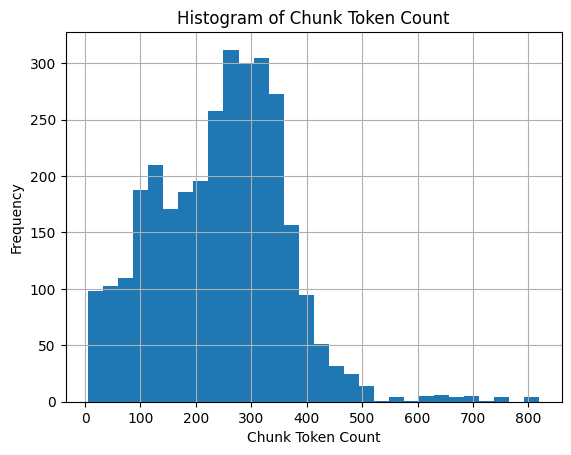

In [ ]:
#Plot chunk_token_count distribution
import matplotlib.pyplot as plt

df['chunk_token_count'].hist(bins=30)
plt.xlabel('Chunk Token Count')
plt.ylabel('Frequency')
plt.title('Histogram of Chunk Token Count')
plt.show()

In [ ]:
min_token_length = 30

for row in df[df["chunk_token_count"] <= min_token_length].sample(20).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 23.75 | Text: 1162 Appendix H This OpenStax book is available for free at http://cnx.org/content/col11992/1.8
Chunk token count: 27.25 | Text: 328 Chapter 9 Cratered Worlds This OpenStax book is available for free at http://cnx.org/content/col11992/1.8
Chunk token count: 19.75 | Text: Why or why not? Chapter 13 Comets and Asteroids: Debris of the Solar System 485
Chunk token count: 29.5 | Text: 420 Chapter 12 Rings, Moons, and Pluto This OpenStax book is available for free at http://cnx.org/content/col11992/1.8
Chunk token count: 12.0 | Text: Chapter 22 Stars from Adolescence to Old Age 803
Chunk token count: 13.5 | Text: Chapter 2 Observing the Sky: The Birth of Astronomy 43
Chunk token count: 29.0 | Text: 1110 Chapter 30 Life in the Universe This OpenStax book is available for free at http://cnx.org/content/col11992/1.8
Chunk token count: 12.0 | Text: Chapter 22 Stars from Adolescence to Old Age 791
Chunk token count: 15.75 | Text: Chapter 7 Other Worlds: An Introd

In [ ]:
pdf_pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pdf_pages_and_chunks_over_min_token_len[:2]

[{'page_number': -6,
  'sentence_chunk': 'Astronomy   Senior Contributing Authors  Andrew Fraknoi, Foothill College David Morrison, National Aeronautics and Space Administration Sidney C. Wolff, National Optical Astronomy Observatories (Emeritus)',
  'chunk_char_count': 204,
  'chunk_word_count': 26,
  'chunk_token_count': 51.0},
 {'page_number': -5,
  'sentence_chunk': 'TABLE OF CONTENTS Preface 1 1 Science and the Universe: A Brief Tour 11 1.1 The Nature of Astronomy 13 1.2 The Nature of Science 13 1.3 The Laws of Nature 15 1.4 Numbers in Astronomy 15 1.5 Consequences of Light Travel Time 17 1.6 A Tour of the Universe 18 1.7 The Universe on the Large Scale 23 1.8 The Universe of the Very Small 27 1.9 A Conclusion and a Beginning 28 2 Observing the Sky: The Birth of Astronomy 31 2.1 The Sky Above 32 2.2 Ancient Astronomy 42 2.3 Astrology and Astronomy 49 2.4 The Birth of Modern Astronomy 54 3 Orbits and Gravity 69 3.1 The Laws of Planetary Motion 70 3.2 Newton’s Great Synthesis 76 3.3

In [ ]:
random.sample(pdf_pages_and_chunks_over_min_token_len, k = 1)

[{'page_number': 300,
  'sentence_chunk': 'Thought Questions 18. If you wanted to live where the chances of a destructive earthquake were small, would you pick a location near a fault zone, near a mid ocean ridge, near a subduction zone, or on a volcanic island such as Hawaii? What are the relative risks of earthquakes at each of these locations?19. Which type of object would likely cause more damage if it struck near an urban area: a small metallic object or a large stony/icy one?20. If all life were destroyed on Earth by a large impact, would new life eventually form to take its place? Explain how conditions would have to change for life to start again on our planet.21. Why is a decrease in Earth’s ozone harmful to life?',
  'chunk_char_count': 689,
  'chunk_word_count': 125,
  'chunk_token_count': 172.25}]

In [ ]:
df = pd.DataFrame(pdf_pages_and_chunks_over_min_token_len)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,3039.00,3039.00,3039.00,3039.00
mean,590.31,995.24,166.54,248.81
std,335.47,453.86,76.90,113.47
min,-6.00,121.00,16.00,30.25
25%,301.00,645.50,106.00,161.38
50%,593.00,1028.00,172.00,257.00
75%,876.50,1294.50,219.00,323.62
max,1190.00,3277.00,514.00,819.25


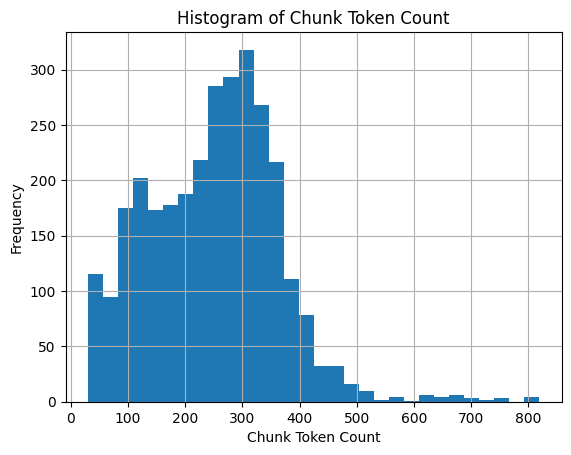

In [ ]:
#Plot chunk_token_count distribution
import matplotlib.pyplot as plt

df['chunk_token_count'].hist(bins=30)
plt.xlabel('Chunk Token Count')
plt.ylabel('Frequency')
plt.title('Histogram of Chunk Token Count')
plt.show()

##Embedding the Text Chunks

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [ ]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="BAAI/bge-base-en-v1.5", device= device)

In [ ]:
print(embedding_model.max_seq_length)

512


In [ ]:
%%time

#embedding_model.to("cpu")

for item in pdf_pages_and_chunks_over_min_token_len:
  item["embedding"] = embedding_model.encode(item["sentence_chunk"])

CPU times: user 38min 52s, sys: 1.89 s, total: 38min 54s
Wall time: 39min 22s


In [ ]:
pdf_pages_and_chunks_over_min_token_len[846]

{'page_number': 336,
 'sentence_chunk': 'Explain why it’s difficult to learn about Venus from Earth-based observation alone Describe the history of our interest in Mars before the Space Age Compare the basic physical properties of Earth, Mars, and Venus, including their orbits As you might expect from close neighbors, Mars and Venus are among the brightest objects in the night sky. The average distance of Mars from the Sun is 227 million kilometers (1.52 AU), or about half again as far from the Sun as Earth. Venus’ orbit is very nearly circular, at a distance of 108 million kilometers (0.72 AU) from the Sun. Like Mercury, Venus sometimes appears as an “evening star” and sometimes as a “morning star.”Venus approaches Earth more closely than does any other planet: at its nearest, it is only 40 million kilometers from us. The closest Mars ever gets to Earth is about 56 million kilometers. Appearance Venus appears very bright, and even a small telescope reveals that it goes through phases 

In [ ]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pdf_pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [ ]:
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-6,Astronomy Senior Contributing Authors Andre...,204,26,51.00,[-4.05298397e-02 2.78794598e-02 1.47407586e-...
1,-5,TABLE OF CONTENTS Preface 1 1 Science and the ...,1101,212,275.25,[-3.06523833e-02 3.48963309e-04 4.42484254e-...
2,-4,5.3 Spectroscopy in Astronomy 161 5.4 The Stru...,1276,213,319.00,[-1.32404180e-04 3.85757573e-02 8.55607912e-...
3,-3,11 The Giant Planets 379 11.1 Exploring the Ou...,1198,203,299.50,[-5.13935462e-02 4.99722809e-02 -4.42134365e-...
4,-2,17.1 The Brightness of Stars 591 17.2 Colors o...,1455,247,363.75,[-1.55311627e-02 4.72033620e-02 2.89723184e-...


In [ ]:
text_chunks_and_embedding_df_load['embedding']

,embedding
0,[-4.05298397e-02 2.78794598e-02 1.47407586e-...
1,[-3.06523833e-02 3.48963309e-04 4.42484254e-...
2,[-1.32404180e-04 3.85757573e-02 8.55607912e-...
3,[-5.13935462e-02 4.99722809e-02 -4.42134365e-...
4,[-1.55311627e-02 4.72033620e-02 2.89723184e-...
...,...
3034,[-6.56531891e-03 4.27780338e-02 -3.60181779e-...
3035,[-2.46736333e-02 2.27722619e-02 -4.06544209e-...
3036,[-4.50315066e-02 3.33352666e-03 -4.27010916e-...
3037,[-4.62551899e-02 2.18304954e-02 -5.15463091e-...


## Search and Answer

In [3]:
import random

import torch
import numpy as np
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([3039, 768])

In [ ]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="BAAI/bge-base-en-v1.5",
                                      device=device)

In [5]:
query = "Pluto"
print(f"Query: {query}")

query_embedding = embedding_model.encode(query, convert_to_tensor=True).to(device)

from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: Pluto
Time take to get scores on 3039 embeddings: 0.02336 seconds.


torch.return_types.topk(
values=tensor([0.7197, 0.7039, 0.6970, 0.6807, 0.6798], device='cuda:0'),
indices=tensor([1075, 1081, 1085, 1073, 1132], device='cuda:0'))

In [6]:
pages_and_chunks[1081]['sentence_chunk']

'The Nature of Pluto Using data from the New Horizons probe, astronomers have measured the diameter of Pluto as 2370 kilometers, only 60 perent as large as our Moon. From the diameter and mass, we find a density of 1.9 g/cm3, suggesting that Pluto is a mixture of rocky materials and water ice in about the same proportions as many outer-planet moons. Parts of Pluto’s surface are highly reflective, and its spectrum demonstrates the presence on its surface of frozen methane, carbon monoxide, and nitrogen. The maximum surface temperature ranges from about 50 K when Pluto is farthest from the Sun to 60 K when it is closest. Even this small difference is enough to cause a partial sublimation (going from solid to gas) of the methane and nitrogen ice. This generates an atmosphere when Pluto is close to the Sun, and it freezes out when Pluto is farther away. Observations of distant stars seen through this thin atmosphere indicate that the surface pressure is about a ten-thousandth of Earth’s. B

In [7]:
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [8]:
print(f"Query: '{query}'\n")
print("Results:")

for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'Pluto'

Results:
Score: 0.7197
Text:
Figure 12.18. Comparison of the Sizes of Pluto and Its Moon Charon with Earth.
This graphic vividly shows how tiny Pluto is relative to a terrestrial planet
like Earth. That is the primary justification for putting Pluto in the class of
dwarf planets rather than terrestrial planets. (credit: modification of work by
NASA) To many astronomers, Pluto seemed like the odd cousin that everyone hopes
will not show up at the next family reunion. Neither its path around the Sun nor
its size resembles either the giant planets or the terrestrial planets. In the
1990s, astronomers began to discover additional small objects in the far outer
solar system, showing that Pluto was not unique. We will discuss these trans-
neptunian objects later with other small bodies, in the chapter on Comets and
Asteroids: Debris of the Solar System. One of them (called Eris) is nearly the
same size as Pluto, and another ( Makemake) is substantially smaller. It became
clea

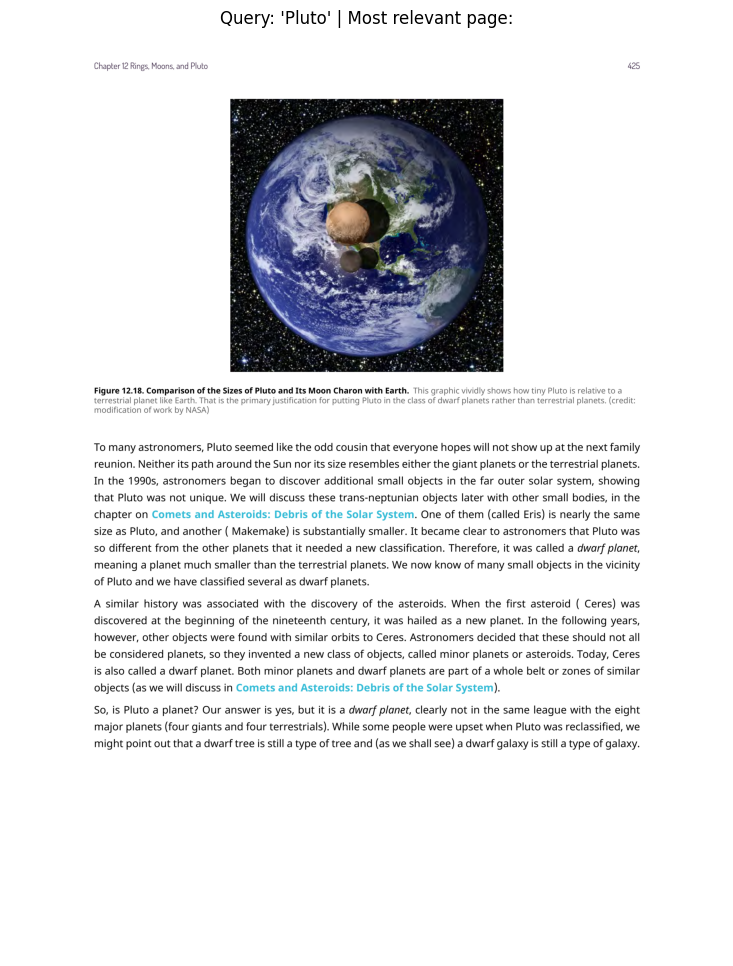

In [9]:
import fitz

pdf_path = "/content/Astronomy.pdf"
doc = fitz.open(pdf_path)
page = doc.load_page(425+6)

img = page.get_pixmap(dpi=300)
doc.close()

img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 12))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off')
plt.show()

In [10]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """


    query_embedding = model.encode(query, convert_to_tensor=True)

    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores, k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """

    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)

    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [11]:
print_top_results_and_scores(query=query, embeddings=embeddings)

Time taken to get scores on 3039 embeddings: 0.00011 seconds.
Query: Pluto

Results:
Score: 0.7197
Figure 12.18. Comparison of the Sizes of Pluto and Its Moon Charon with Earth.
This graphic vividly shows how tiny Pluto is relative to a terrestrial planet
like Earth. That is the primary justification for putting Pluto in the class of
dwarf planets rather than terrestrial planets. (credit: modification of work by
NASA) To many astronomers, Pluto seemed like the odd cousin that everyone hopes
will not show up at the next family reunion. Neither its path around the Sun nor
its size resembles either the giant planets or the terrestrial planets. In the
1990s, astronomers began to discover additional small objects in the far outer
solar system, showing that Pluto was not unique. We will discuss these trans-
neptunian objects later with other small bodies, in the chapter on Comets and
Asteroids: Debris of the Solar System. One of them (called Eris) is nearly the
same size as Pluto, and anothe

##Getting the LLM for RAG

In [12]:
!nvidia-smi

Thu Feb  5 11:52:33 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   39C    P0             27W /   72W |     701MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [13]:
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_in_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_in_gb} GB")

Available GPU memory: 22 GB


In [14]:
if gpu_memory_in_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_in_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_in_gb < 8.1:
    print(f"GPU memory: {gpu_memory_in_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True
    model_id = "google/gemma-2b-it"
elif gpu_memory_in_gb < 19.0:
    print(f"GPU memory: {gpu_memory_in_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False
    model_id = "google/gemma-2b-it"
elif gpu_memory_in_gb > 19.0:
    print(f"GPU memory: {gpu_memory_in_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 22 | Recommend model: Gemma 7B in 4-bit or float16 precision.
use_quantization_config set to: False
model_id set to: google/gemma-7b-it


In [15]:
torch.cuda.get_device_capability(0)[0]

8

In [16]:
from huggingface_hub import login

login(token="Your HF access token goes here.")

###Loading the LLM Locally

In [ ]:
!pip install bitsandbytes accelerate

In [ ]:
!pip install flash-attn

In [19]:
import transformers

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available


# 1. Create a quantization config
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit = True,
                                         bnb_4bit_compute_dtype = torch.float16)

# 2. Flash Attention 2. Requires compute capability of >8.0
if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
    attn_implementation = "flash_attention_2"
    print("Using Flash Attention 2")
else:
    attn_implementation = "sdpa"
    print("Using Scaled Dot Product Attention")

# 3. Pick a model to use
model_id = model_id

# 4. Instantiate Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)

# 5. Instantiate the model
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                             torch_dtype = torch.float16,
                                             quantization_config = quantization_config if use_quantization_config else None,
                                             low_cpu_mem_usage=False,
                                             attn_implementation=attn_implementation)

if not use_quantization_config: # quantization takes care of device setting automatically, so if it's not used, send model to GPU
    llm_model.to("cuda")

In [21]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 3072, padding_idx=0)
    (layers): ModuleList(
      (0-27): 28 x GemmaDecoderLayer(
        (self_attn): GemmaAttention(
          (q_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (k_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (v_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=3072, bias=False)
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=3072, out_features=24576, bias=False)
          (up_proj): Linear(in_features=3072, out_features=24576, bias=False)
          (down_proj): Linear(in_features=24576, out_features=3072, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm((3072,), eps=1e-06)
        (post_attention_layernorm): GemmaRMSNorm((3072,), eps=1e-06)
      )
    )
    (norm): GemmaRMSNorm((3072,)

In [22]:
is_flash_attn_2_available()

False

In [23]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

8537680896

In [24]:
def get_model_mem_size(model: torch.nn.Module):
    """
    Get how much memory a PyTorch model takes up.

    See: https://discuss.pytorch.org/t/gpu-memory-that-model-uses/56822
    """
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 17075362816,
 'model_mem_mb': 16284.33,
 'model_mem_gb': 15.9}

In [25]:
input_text = "What are the rings of planet Saturn made of?"
print(f"Input text:\n{input_text}")

dialogue_template = [
    {"role": "user",
     "content": input_text}
]

prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
What are the rings of planet Saturn made of?

Prompt (formatted):
<bos><start_of_turn>user
What are the rings of planet Saturn made of?<end_of_turn>
<start_of_turn>model



In [26]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
print(f"Model input (tokenized):\n{input_ids}\n")

outputs = llm_model.generate(**input_ids, max_new_tokens=256)
print(f"Model output (tokens):\n{outputs[0]}\n")

Model input (tokenized):
{'input_ids': tensor([[     2,      2,    106,   1645,    108,   1841,    708,    573,  20221,
            576,  14908,  52445,   1644,    576, 235336,    107,    108,    106,
           2516,    108]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}

Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   1841,    708,    573,  20221,
           576,  14908,  52445,   1644,    576, 235336,    107,    108,    106,
          2516,    108, 126466, 235303, 235256,  20221,    708,   1644,    576,
          8357,    578,  12891,  16071, 235269,    780,   5998, 235265,   2365,
           708,    780,   1644,    576,   8336,   5998,   1154,    573,  20221,
           576,  48453, 235265,      1], device='cuda:0')

CPU times: user 2.26 s, sys: 147 ms, total: 2.4 s
Wall time: 2.8 s


In [27]:
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
What are the rings of planet Saturn made of?<end_of_turn>
<start_of_turn>model
Saturn's rings are made of ice and dust particles, not metal. They are not made of pure metal like the rings of Jupiter.<eos>



In [28]:
print(f"Input text: {input_text}\n")
print(f"Output text:\n{outputs_decoded.replace(prompt, '').replace('<bos>', '').replace('<eos>', '')}")

Input text: What are the rings of planet Saturn made of?

Output text:
Saturn's rings are made of ice and dust particles, not metal. They are not made of pure metal like the rings of Jupiter.


In [29]:
astronomy_questions = [
    "What physical processes determine how long a star remains on the main sequence?",
    "Why do massive stars evolve more quickly than low-mass stars despite having more fuel?",
    "What roles do convection and radiation play inside stars, and how do you identify which zone dominates?",
    "How do nuclear reaction rates influence the internal structure of a star?",
    "What physical conditions lead a star to end its life as a white dwarf, neutron star, or black hole?",
    "Why is the spectrum of a star not a perfect blackbody?",
    "What determines the width and shape of spectral lines in stellar spectra?",
    "In what situations does the assumption of local thermodynamic equilibrium break down in a stellar atmosphere?",
    "How does the opacity of a star's atmosphere influence the emergent spectrum?",
    "What information about a star can be inferred from its spectral classification?",
    "What evidence in spiral galaxies suggests the presence of dark matter?",
    "Why do elliptical galaxies contain little cold gas compared to spiral galaxies?",
    "How do astronomers infer the orbital motions of stars inside a galaxy?",
    "What physical processes influence the shape and structure of galaxies over time?",
    "How do galaxy interactions and mergers affect galactic evolution?",
    "What observations support the idea that the universe is expanding?",
    "Why is the cosmic microwave background considered strong evidence for the early hot universe?",
    "How do astronomers measure distances to very distant galaxies?",
    "What distinguishes dark matter from dark energy in terms of their observable effects on the universe?",
    "What role do galaxy clusters play in understanding large-scale structure?",
    "What physical conditions lead to the formation of an accretion disk around a compact object?",
    "Why are some black holes strong sources of X-rays?",
    "How do astronomers determine whether an observed compact object is likely a neutron star or a black hole?",
    "What processes can accelerate particles to relativistic speeds in astrophysical environments?",
    "How do supernova explosions influence their surrounding interstellar medium?",
    "How do transiting exoplanets produce measurable changes in starlight?",
    "What factors determine whether a planet can retain an atmosphere?",
    "How do planetary migration theories explain the presence of hot Jupiters?",
    "Why are some planetary systems so different from our solar system?",
    "What methods allow astronomers to study the atmospheres of exoplanets?",
    "What factors limit the sensitivity of a ground-based telescope?",
    "How do astronomers distinguish between signal and noise in an astronomical observation?",
    "Why are space telescopes necessary for certain wavelengths of light?",
    "What determines the resolving power of an astronomical instrument (qualitatively)?",
    "How do different types of detectors differ in how they measure incoming light?"
]

query_list = astronomy_questions

In [30]:
import random
query = random.choice(query_list)

print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: Why are some planetary systems so different from our solar system?
Time taken to get scores on 3039 embeddings: 0.00009 seconds.


(tensor([0.7576, 0.7575, 0.7472, 0.7362, 0.7322], device='cuda:0'),
 tensor([ 591,  649, 1313, 1282,  645], device='cuda:0'))

##Augment the Input Query

In [54]:
def prompt_formatter(query: str, context_items: list[dict]) -> str:

  context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])
  base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""
  base_prompt = base_prompt.format(context=context, query=query)

  dialogue_template = [
        {"role": "user",
        "content": base_prompt}
  ]


  prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                         tokenize=False,
                                         add_generation_prompt=True)
  return prompt

In [55]:
query = random.choice(query_list)
print(f"\nQuery: {query}\n")

scores, indices = retrieve_relevant_resources(query=query, embeddings=embeddings)

context_items = [pages_and_chunks[i] for i in indices]

prompt = prompt_formatter(query=query, context_items=context_items)
print("\nPrompt:")
print(prompt)


Query: What evidence in spiral galaxies suggests the presence of dark matter?

Time taken to get scores on 3039 embeddings: 0.00022 seconds.

Prompt:
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.

Now use the following context items to answer the user query:
- What’s left? One possibility is that the dark matter is composed of exotic subatomic particles of a type not yet detected on Earth. Very sophisticated (and difficult) experiments are now under way to look for such particles. Stay tuned to see whether anything like that turns up. We should add that the problem of dark matter is by no means confined to the Milky Way. Observations show that dark matter must also be present in other galaxies (whose outer regions also orbit too fast “f

In [63]:
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

outputs = llm_model.generate(**input_ids,
                             temperature=0.7,
                             do_sample=True,
                             max_new_tokens=256)

output_text = tokenizer.decode(outputs[0])

print(f"\nQuery: {query}\n")
print(f"\nRAG answer:\n{output_text.replace(prompt, '')}\n\n")


Query: How do astronomers measure distances to very distant galaxies?


RAG answer:
<bos>**Relevant passages:**

"In spiral galaxies, such as the Andromeda galaxy we discussed earlier, recent measurements of the rotation speeds of the outer parts of nearby galaxies suggest that they too have extended distributions of dark matter around the visible disk of stars and dust."

"The clustering of galaxies can be used to derive the total amount of mass in a given region of space, while visible radiation is a good indicator of where the luminous mass is."

**Answer:**

The presence of dark matter in spiral galaxies is suggested by the extended distributions of dark matter around the visible disk of stars and dust in nearby galaxies. The clustering of galaxies can be used to derive the total amount of mass in a given region of space. Therefore, the presence of dark matter in spiral galaxies can be inferred from the mass-to-light ratio of the galaxy.<eos>




In [58]:
def ask(query,
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True,
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """

    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)

    context_items = [pages_and_chunks[i] for i in indices]

    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu()

    prompt = prompt_formatter(query=query,
                              context_items=context_items)

    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)

    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    if return_answer_only:
        return output_text

    return output_text, context_items

In [64]:
query = random.choice(query_list)
print(f"Query: {query}")

answer, context_items = ask(query=query,
                            temperature=0.7,
                            max_new_tokens=512,
                            return_answer_only=False)

print("\n==========================================================================================================================\n")
print(f"Answer:\n")
print_wrapped(answer)
print("\n==========================================================================================================================\n")
print(f"\nContext items:\n")
context_items

Query: Why are some planetary systems so different from our solar system?
Time taken to get scores on 3039 embeddings: 0.00016 seconds.


Answer:

**Relevant passages:**  "Probably all planetary systems have formed in similar
ways, but many exoplanet systems have evolved along quite different paths."  "A
few percent of exoplanet systems have "hot Jupiters," massive planets that orbit
close to their stars, and many exoplanets are also in eccentric orbits."  "These
two characteristics are fundamentally different from the attributes of gas giant
planets in our own solar system and suggest that giant planets can migrate
inward from their place of formation where it is cold enough for ice to form."
**Answer:**  Planetary systems are different from our solar system because they
have evolved along different paths. Some exoplanet systems have "hot Jupiters,"
massive planets that orbit close to their stars, while others have eccentric
orbits. These characteristics are fundamentally different fr

[{'page_number': 234,
  'sentence_chunk': 'Humans have set foot on the Moon and returned samples of its surface soil for laboratory analysis (Figure 7.2). We have even discovered other places in our solar system that might be able to support some kind of life.1 The generic term for a group of planets and other bodies circling a star is planetary system. Ours is called the solar system because our Sun is sometimes called Sol. Strictly speaking, then, there is only one solar system; planets orbiting other stars are in planetary systems.234 Chapter 7 Other Worlds: An Introduction to the Solar System This OpenStax book is available for free at http://cnx.org/content/col11992/1.8',
  'chunk_char_count': 640,
  'chunk_word_count': 105,
  'chunk_token_count': 160.0,
  'embedding': array([ 1.66014535e-03, -3.24648572e-03,  1.04405517e-02,  1.68398339e-02,
          1.31824007e-02, -2.88360212e-02,  2.29096748e-02,  4.12826948e-02,
         -2.61364263e-02, -4.28830236e-02,  3.17075700e-02, -1.